In [4]:
!git clone https://github.com/JASCRAJ/stylized-neural-painting.git

Cloning into 'stylized-neural-painting'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 230 (delta 90), reused 61 (delta 61), pack-reused 110 (from 1)
Receiving objects: 100% (230/230), 10.60 MiB | 17.28 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [5]:
cd stylized-neural-painting

/content/stylized-neural-painting/stylized-neural-painting


In [6]:
import gdown
import zipfile
import os


gdrive_link = 'https://drive.google.com/file/d/1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG/view?usp=sharing'

# Extract the file ID from the link
file_id = gdrive_link.split('/d/')[1].split('/')[0]
download_url = f'https://drive.google.com/uc?id={file_id}'

#Download the ZIP file
output = 'checkpoints_G_oilpaintbrush.zip'
gdown.download(download_url, output, quiet=False)

# Unzip the file
unzip_path = '/content/stylized-neural-painting/'
os.makedirs(unzip_path, exist_ok=True)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

print(f"Files extracted to: {unzip_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG
From (redirected): https://drive.google.com/uc?id=1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG&confirm=t&uuid=73fac3fb-dd4f-4c0a-aefb-b6b49604f294
To: /content/stylized-neural-painting/stylized-neural-painting/checkpoints_G_oilpaintbrush.zip
100%|██████████| 181M/181M [00:03<00:00, 53.6MB/s]


Files extracted to: /content/stylized-neural-painting/


In [9]:
import numpy as np
import torch
from painter import Painter
from types import SimpleNamespace

# --- Fake args as expected by Painter ---
args = SimpleNamespace(
    renderer='oilpaintbrush',
    renderer_checkpoint_dir='/content/stylized-neural-painting/checkpoints_G_oilpaintbrush',
    net_G='zou-fusion-net',
    canvas_color='white',
    canvas_size=512,
    m_grid=5,
    max_m_strokes=1500,
    disable_preview=True,
    output_dir='./output',
    img_path='',
    keep_aspect_ratio=False,
    beta_L1=1.0,
    with_ot_loss=False,
    beta_ot=0.1,
    lr=0.002,
)

# --- Initialize painter with net_G ---
args.img_path = '' # not giving any image,strokes got already
pt = Painter(args=args)
pt._load_checkpoint()
pt.net_G.eval()

# --- Load stroke parameters from npz
data = np.load("NST_test_strokes.npz")
x_ctt = data["x_ctt"]     # [25, 60, 5]
x_color = data["x_color"] # [25, 60, 6]
x_alpha = data["x_alpha"] # [25, 60, 1]

# --- Concatenate and convert to tensor
x = np.concatenate([x_ctt, x_color, x_alpha], axis=-1)  # [25, 60, 12]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- Concatenate and convert to tensor (NO extra unsqueeze!)
x_np = np.concatenate([x_ctt, x_color, x_alpha], axis=-1)   # (25, 60, 12)
x     = torch.tensor(x_np, dtype=torch.float32, device=device)
pt.x  = x                           # pt.x is now (25, 60, 12)

# --- Normalise, shuffle, render
v_n = pt._normalize_strokes(pt.x)
v_n = pt._shuffle_strokes_and_reshape(v_n)   # <- works again
final_img = pt._render(v_n,
                       save_jpgs=False,
                       save_video=True)



initialize network with normal
loading renderer from pre-trained checkpoint...
rendering canvas...


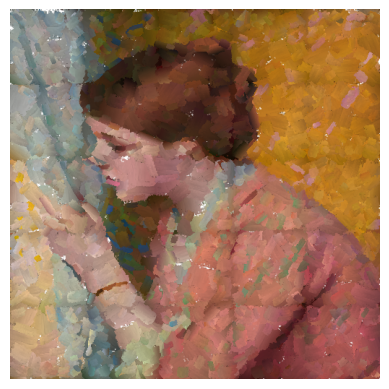

In [10]:
import matplotlib.pyplot as plt
plt.imshow(final_img)
plt.axis('off')
plt.show()
